In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

import pytorch_lightning as pl


In [3]:
from ResSwinUnet import swinUnet_t_3D_Residual

Total number of trainable parameters: 48115676


In [4]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

/home/hice1/bmallya3/.local/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [5]:
data_dir = "./scratch/data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


image shape: torch.Size([1, 333, 229, 224]), label shape: torch.Size([1, 333, 229, 224])


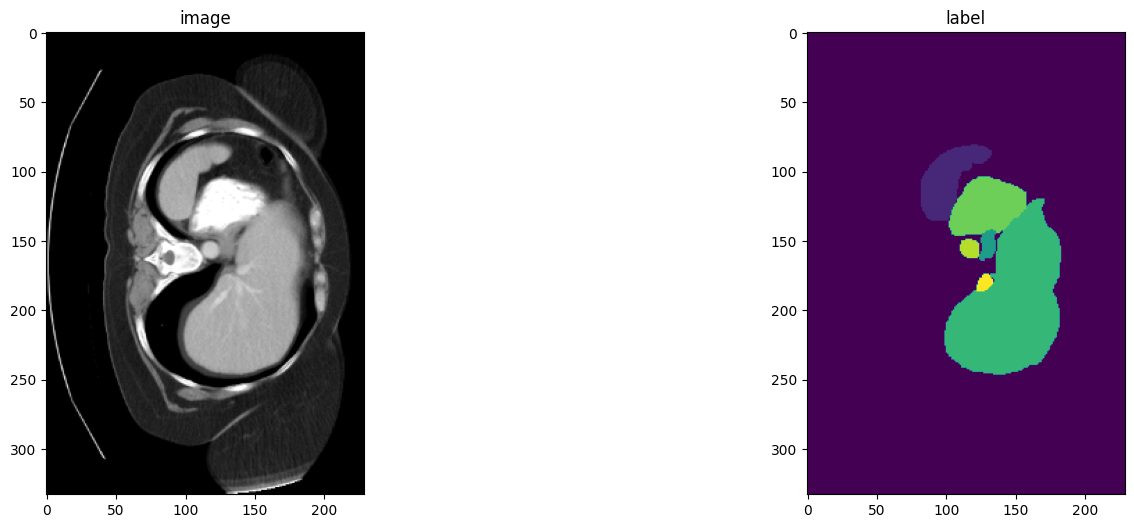

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 4
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
model = swinUnet_t_3D_Residual(in_channel = 1,num_classes=14).to("cuda")

In [8]:
root_dir = "./scratch/Synapse_Datasets_Results/ResSWINUnet_Synapse_Best_Model"

In [9]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

/scratch/999053/ipykernel_1950287/762177899.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pt

<All keys matched successfully>

In [10]:
# for case_num in range(1,6):
#     model.eval()
#     with torch.no_grad():
#         img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
#         img = val_ds[case_num]["image"]
#         label = val_ds[case_num]["label"]
#         val_inputs = torch.unsqueeze(img, 1).cuda()
#         val_labels = torch.unsqueeze(label, 1).cuda()
#         val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model, overlap=0.8)
#         plt.figure("check", (18, 6))
#         plt.subplot(1, 3, 1)
#         plt.title("image")
#         plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
#         plt.subplot(1, 3, 2)
#         plt.title("label")
#         plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
#         plt.subplot(1, 3, 3)
#         plt.title("output")
#         plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
#         plt.show()

In [11]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (128, 128, 128), 4, model)
                print(val_outputs.shape)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
            print("all dices = ",dice_metric(y_pred=val_output_convert, y=val_labels_convert))
        mean_dice_val = dice_metric.aggregate().item()
        #dice_metric.reset()
    return dice_metric,mean_dice_val

In [12]:
max_iterations = 100000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [13]:

# '''
# (1) spleen
# (2) right kidney
# (3) left kidney
# (4) gallbladder
# (5) esophagus
# (6) liver
# (7) stomach
# (8) aorta
# (9) inferior vena cava
# (10) portal vein and splenic vein
# (11) pancreas
# (12) right adrenal gland
# (13) left adrenal gland

# '''

# epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
# all_dices, dice_val = validation(epoch_iterator_val)

In [14]:
# epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
# all_dices, dice_val = validation(epoch_iterator_val)

In [15]:
# print(dice_val)

In [16]:
#CREATING THE MODULE WHICH HANDLES THE TRAINING AND VALIDATION PROCESS

class BratsModel(pl.LightningModule):
    def __init__(self):
        super(BratsModel, self).__init__()
        
        #index of model name 
        #self.index = index
        
        #self.learning_rate = learning_rate 
        self.net = model
        #self.model_name = model_names[self.index]
        
    def forward(self,x):
        
        return self.net(x)
        

    

In [ ]:
# model

In [17]:
saved_model = model

In [18]:
import torch
from monai.transforms import Compose, Resize
from torch.utils.data import DataLoader

# Define the resize transform
resize_transform = Compose([
    Resize(spatial_size=(128, 128, 128), mode='trilinear', align_corners=True)
])

resized_val_loader = []

for batch_idx, batch in enumerate(val_loader):
    x = batch["image"]
    y = batch["label"]
    
    # Initialize a tensor to hold the resized channels
    resized_x = torch.zeros((1, 1, 128, 128, 128), device=x.device)
    
    # Resize each channel separately
    for channel in range(1):
        x_channel = x[0, channel, :, :, :]
        resized_x[0, channel, :, :, :] = resize_transform(x_channel.unsqueeze(0)).squeeze(0)
    
    # Create a new batch with the resized input
    resized_batch = {"image": resized_x, "label": y}
    
    resized_val_loader.append(resized_batch)

# Convert the list of resized batches to a DataLoader
resized_val_loader = DataLoader(resized_val_loader, batch_size=1, shuffle=False)

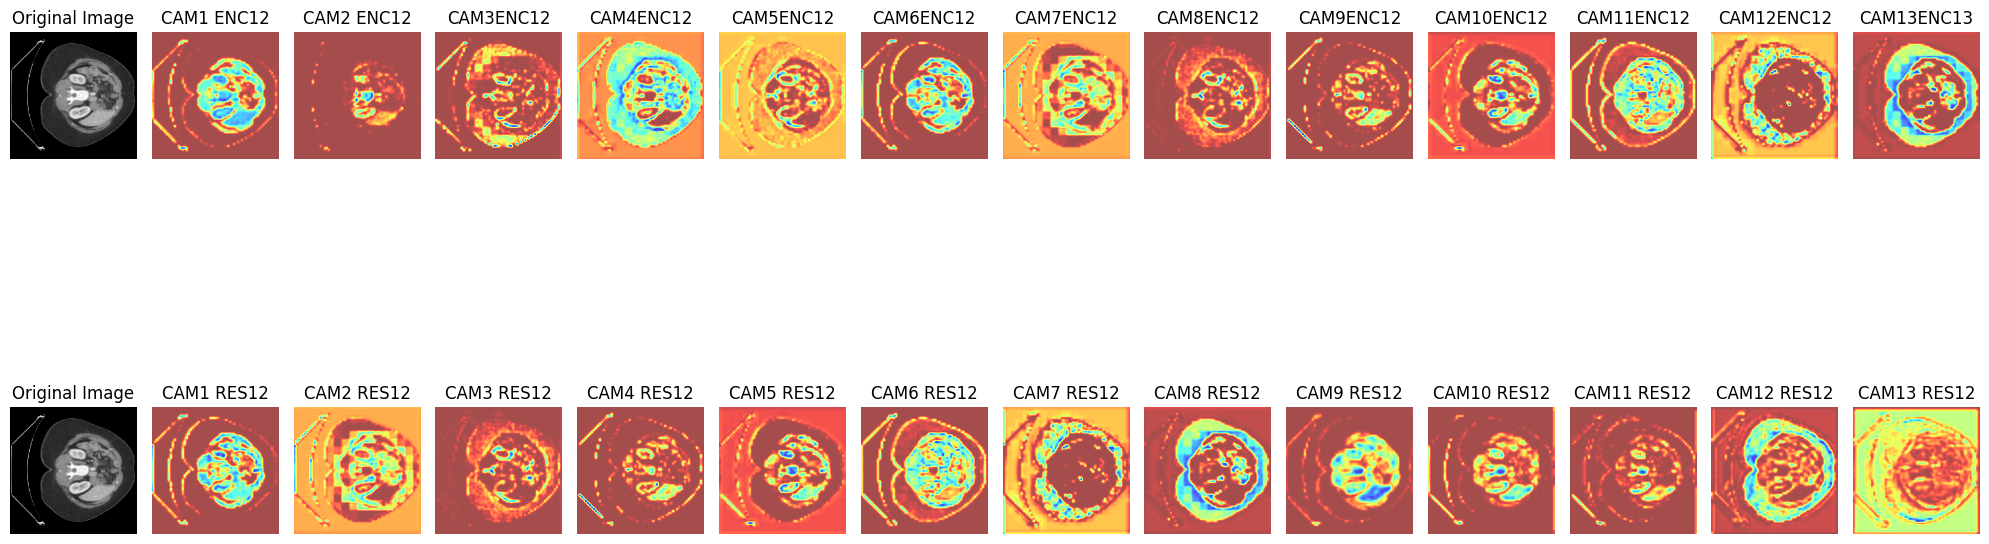

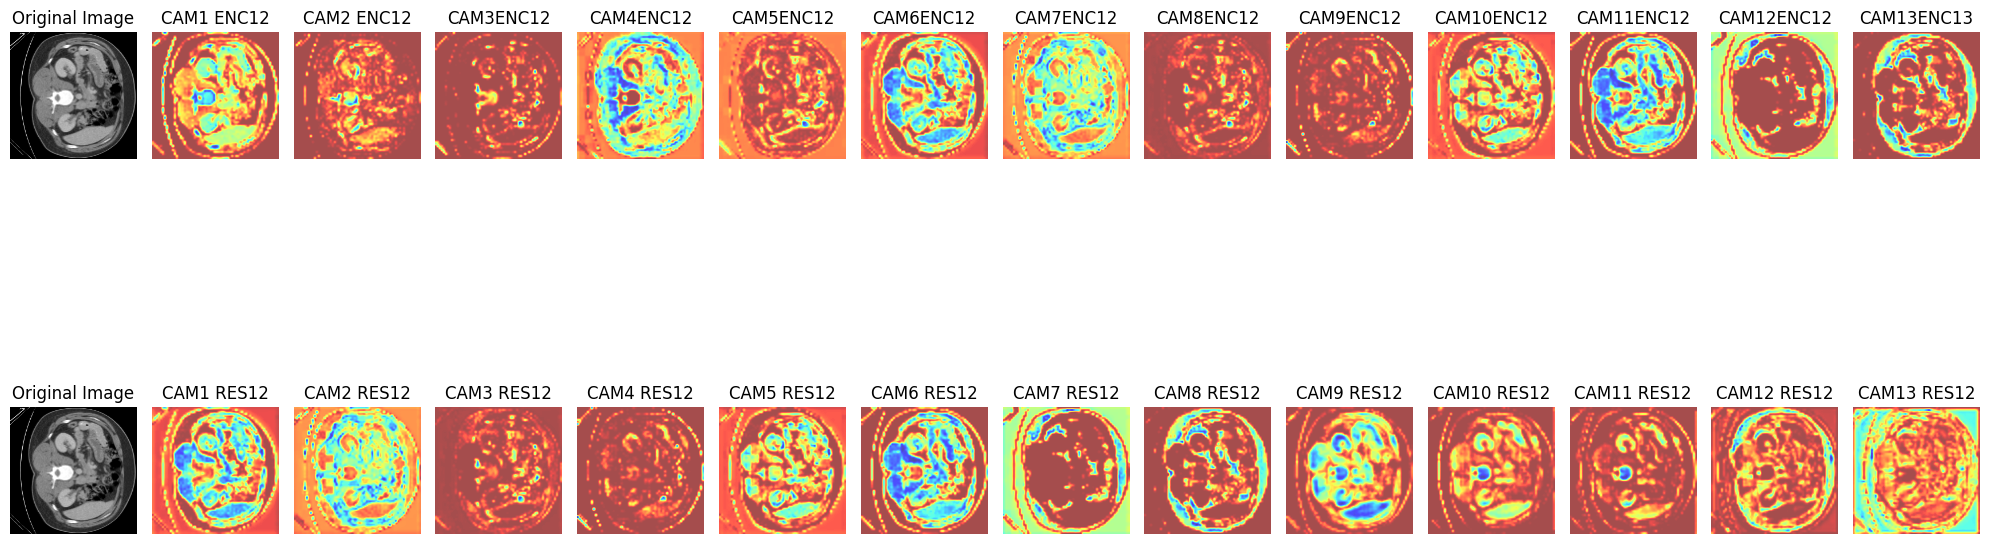

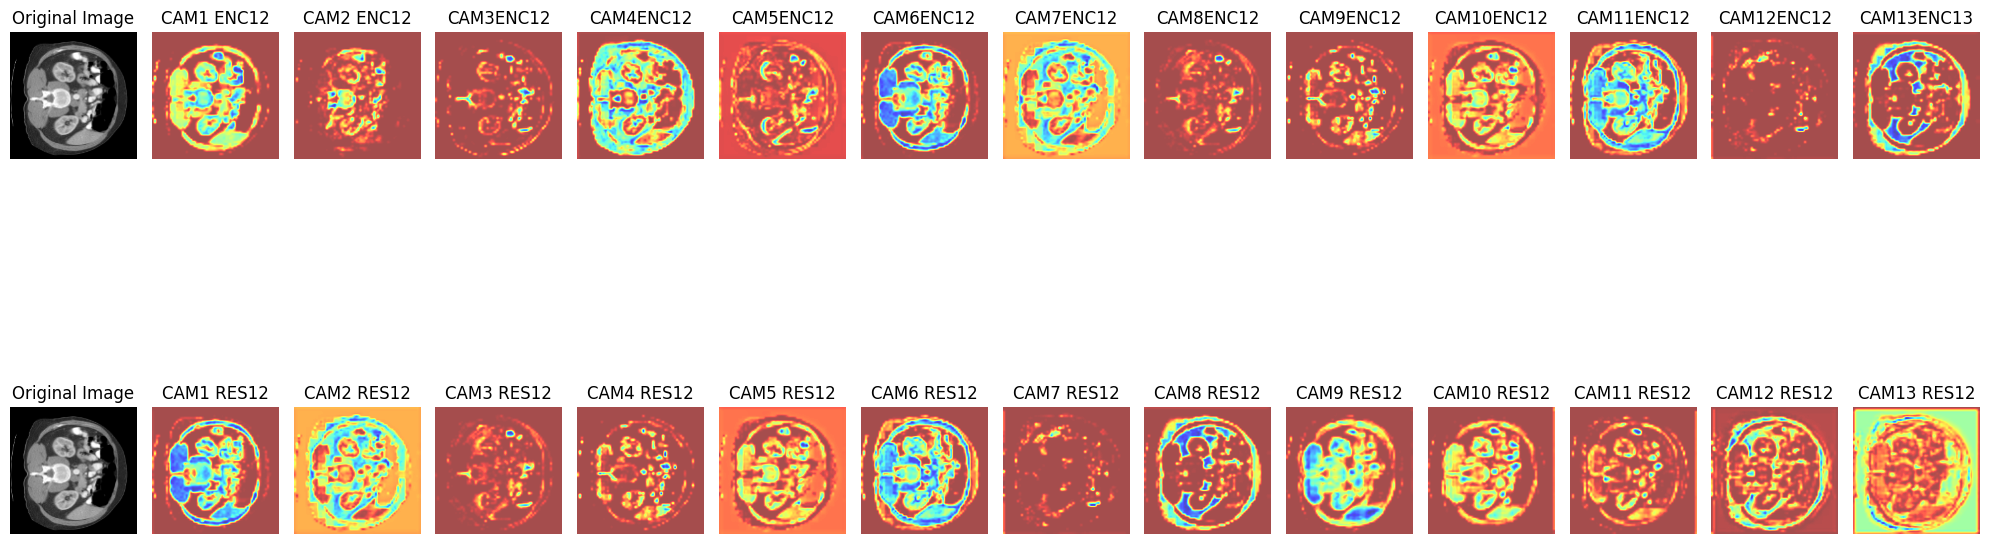

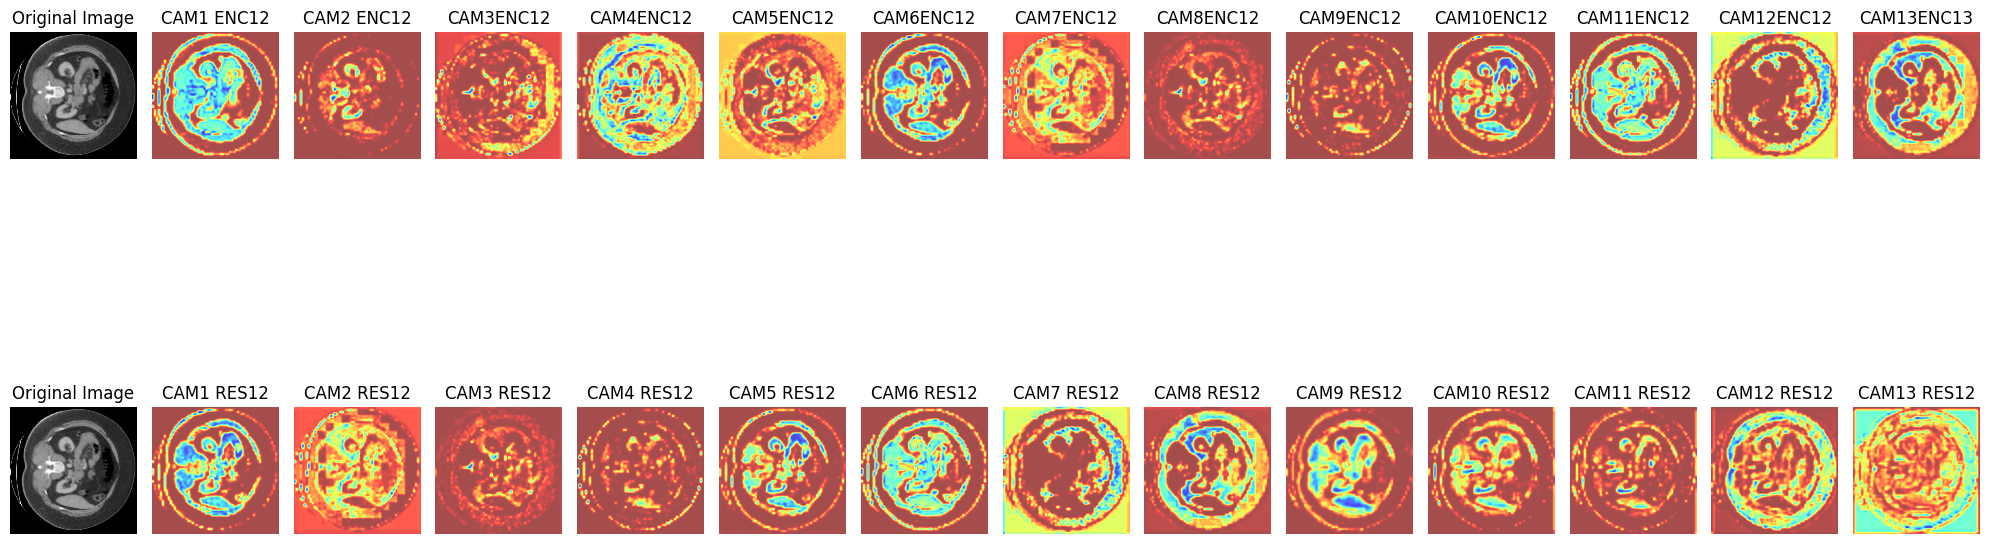

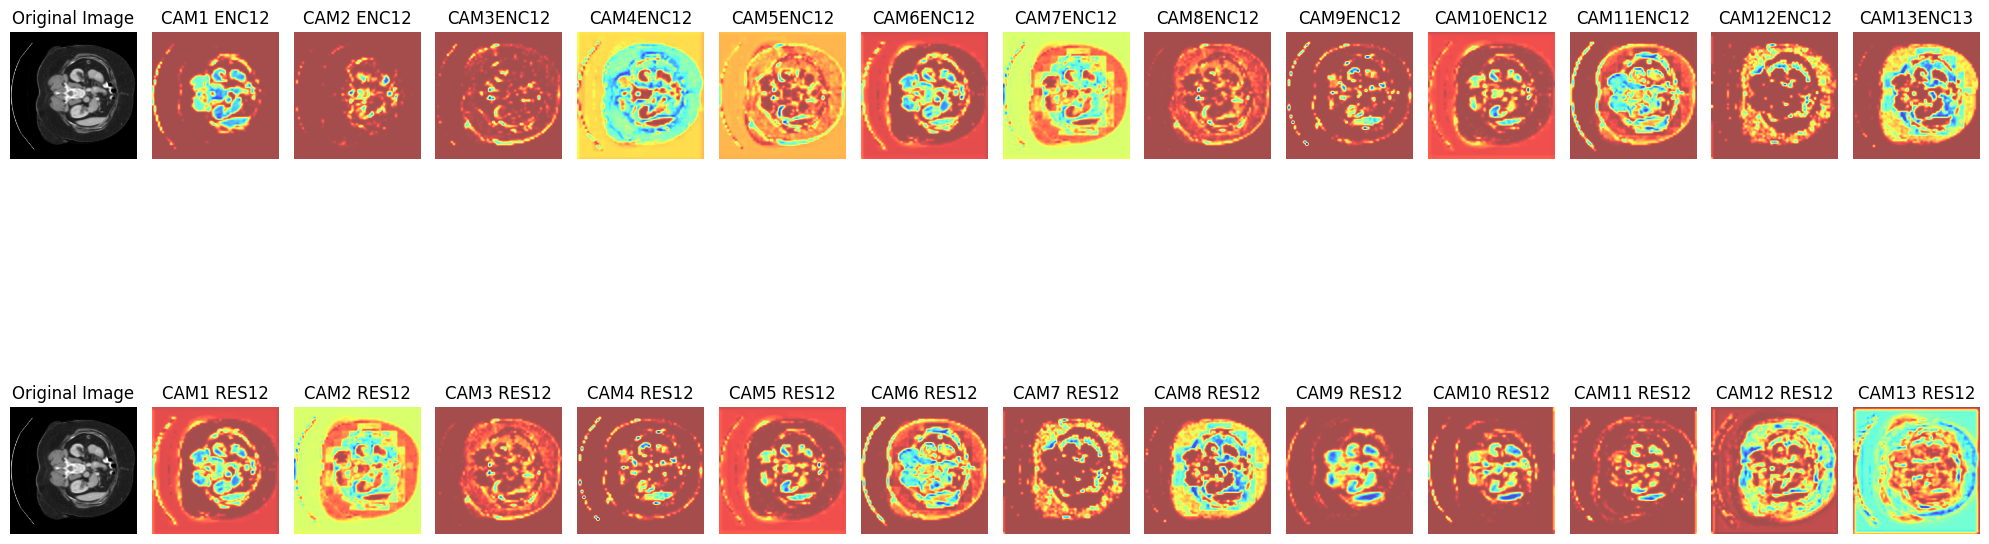

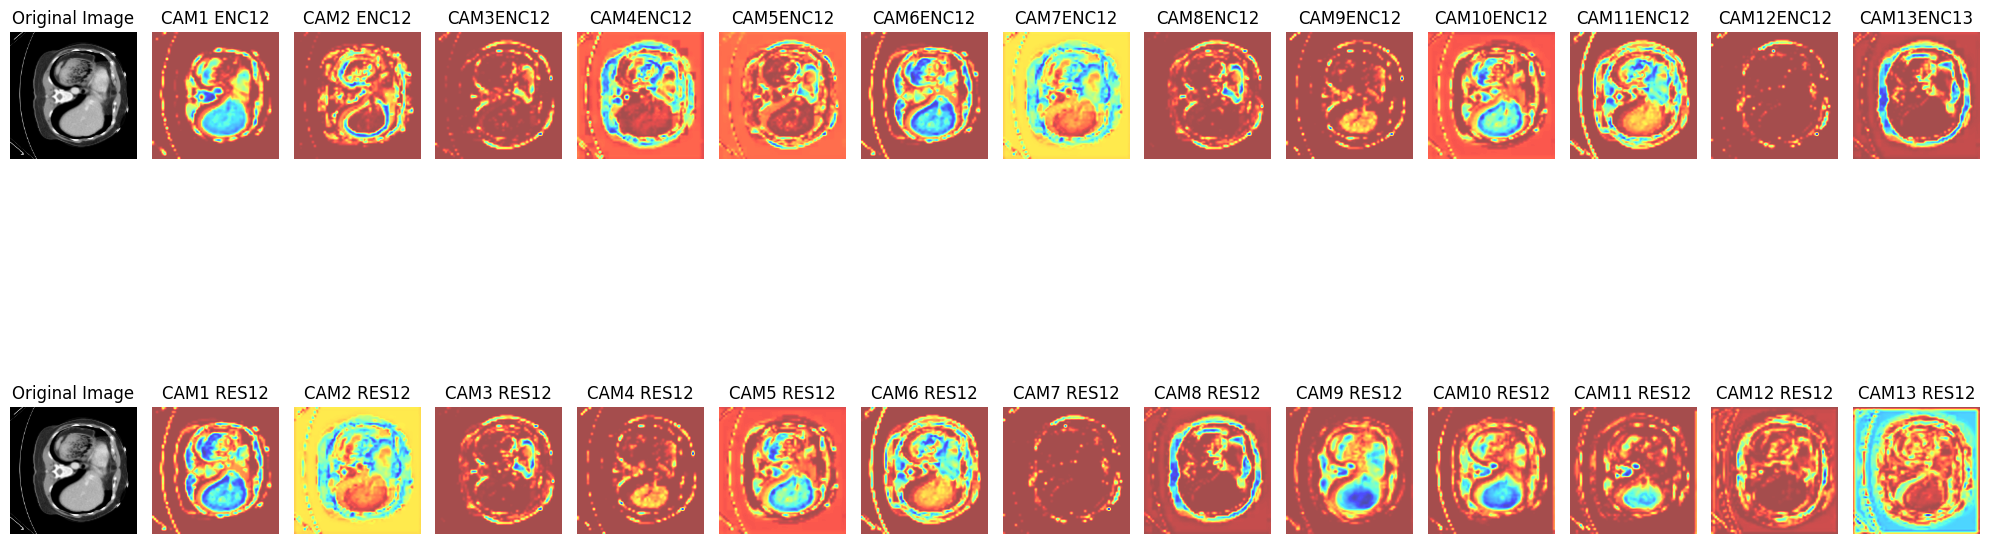

In [22]:
from monai.visualize import GradCAM
import matplotlib.pyplot as plt

#Getting the CAMs for enc12, res12, enc3, res3, enc5, res5 layers 

gcam_enc12 = GradCAM(nn_module=saved_model, target_layers="enc12")
gcam_res12 = GradCAM(nn_module=saved_model, target_layers="res12")

gcam_enc3 = GradCAM(nn_module=saved_model, target_layers="enc3")
gcam_res3 = GradCAM(nn_module=saved_model, target_layers="res3")

gcam_enc5 = GradCAM(nn_module=saved_model, target_layers="enc5")
gcam_res5 = GradCAM(nn_module=saved_model, target_layers="res5")

for batch_idx,batch in enumerate(resized_val_loader):
    images = batch["image"].to('cuda')
    #print(images.size())
    images = torch.squeeze(images,dim=0)
    
    
    
    # Generate GradCAM for classes 0,1,2  
    cam0_enc12 = gcam_enc12(x=images, class_idx=0)
    cam1_enc12 = gcam_enc12(x=images, class_idx=1)
    cam2_enc12 = gcam_enc12(x=images, class_idx=2)
    cam3_enc12 = gcam_enc12(x=images, class_idx=3)
    cam4_enc12 = gcam_enc12(x=images, class_idx=4)
    cam5_enc12 = gcam_enc12(x=images, class_idx=5)
    cam6_enc12 = gcam_enc12(x=images, class_idx=6)
    cam7_enc12 = gcam_enc12(x=images, class_idx=7)
    cam8_enc12 = gcam_enc12(x=images, class_idx=8)
    cam9_enc12 = gcam_enc12(x=images, class_idx=9)
    cam10_enc12 = gcam_enc12(x=images, class_idx=10)
    cam11_enc12 = gcam_enc12(x=images, class_idx=11)
    cam12_enc12 = gcam_enc12(x=images, class_idx=12)
    cam13_enc12 = gcam_enc12(x=images, class_idx=13)
    
    cam0_res12 = gcam_res12(x=images, class_idx=0)
    cam1_res12 = gcam_res12(x=images, class_idx=1)
    cam2_res12 = gcam_res12(x=images, class_idx=2)
    cam3_res12 = gcam_res12(x=images, class_idx=3)
    cam4_res12 = gcam_res12(x=images, class_idx=4)
    cam5_res12 = gcam_res12(x=images, class_idx=5)
    cam6_res12 = gcam_res12(x=images, class_idx=6)
    cam7_res12 = gcam_res12(x=images, class_idx=7)
    cam8_res12 = gcam_res12(x=images, class_idx=8)
    cam9_res12 = gcam_res12(x=images, class_idx=9)
    cam10_res12 = gcam_res12(x=images, class_idx=10)
    cam11_res12 = gcam_res12(x=images, class_idx=11)
    cam12_res12 = gcam_res12(x=images, class_idx=12)
    cam13_res12 = gcam_res12(x=images, class_idx=13)
    
    '''
    cam0_enc3 = gcam_enc3(x=images, class_idx=0)
    cam1_enc3 = gcam_enc3(x=images, class_idx=1)
    cam2_enc3 = gcam_enc3(x=images, class_idx=2)
    
    cam0_res3 = gcam_res3(x=images, class_idx=0)
    cam1_res3 = gcam_res3(x=images, class_idx=1)
    cam2_res3 = gcam_res3(x=images, class_idx=2)
    
    cam0_enc5 = gcam_enc5(x=images, class_idx=0)
    cam1_enc5 = gcam_enc5(x=images, class_idx=1)
    cam2_enc5 = gcam_enc5(x=images, class_idx=2)
    
    cam0_res5 = gcam_res5(x=images, class_idx=0)
    cam1_res5 = gcam_res5(x=images, class_idx=1)
    cam2_res5 = gcam_res5(x=images, class_idx=2)
    '''
    
    cam_images = [cam1_enc12,cam2_enc12,cam3_enc12,
                  cam4_enc12,cam5_enc12,cam6_enc12,cam7_enc12,
                  cam8_enc12,cam9_enc12,cam10_enc12,cam11_enc12,
                  cam12_enc12,cam13_enc12,
                  cam1_res12,cam2_res12,cam3_res12,
                  cam4_res12,cam5_res12,cam6_res12,cam7_res12,
                  cam8_res12,cam9_res12,cam10_res12,cam11_res12,
                  cam12_res12,cam13_res12]
                  
                  
    
    
    cam_image_names = ["CAM1 ENC12", "CAM2 ENC12",
                       "CAM3ENC12", "CAM4ENC12", "CAM5ENC12",
                       "CAM6ENC12", "CAM7ENC12", "CAM8ENC12",
                       "CAM9ENC12", "CAM10ENC12", "CAM11ENC12",
                       "CAM12ENC12","CAM13ENC13",
                       "CAM1 RES12", "CAM2 RES12", "CAM3 RES12",
                       "CAM4 RES12", "CAM5 RES12", "CAM6 RES12",
                       "CAM7 RES12", "CAM8 RES12", "CAM9 RES12",
                       "CAM10 RES12", "CAM11 RES12", "CAM12 RES12",
                       "CAM13 RES12"]
                       
    
    
    #print(cam.shape)
    
    # Visualize the GradCAM results
    # We'll visualize the middle slice of each channel
    fig, axes = plt.subplots(2,14,figsize=(20,10))
    image_names = ["Original Image"]
    
    
    for j in range(0,2):
        for channel in range(1):
        # Visualizing the Original images
            axes[j,channel].imshow(images[0, channel, :, :,80].cpu().numpy(), cmap='gray')
            axes[j,channel].set_title(image_names[channel])
            axes[j,channel].axis('off')
        
        #visualizing the CAMs using the jet heatmaps 
        
        for i in range(1,14):
            axes[j,i].imshow(cam_images[-1+i+5*j][0, 0, :, :,80].cpu().numpy(),cmap='jet', alpha=0.7)
            axes[j,i].set_title(cam_image_names[-1+i+13*j])
            axes[j,i].axis('off')

    
    plt.tight_layout()
    plt.show()
    

In [17]:
# import torch
# from monai.transforms import Compose, Resize
# from monai.visualize import GradCAM
# import matplotlib.pyplot as plt

# # Define the resize transforms
# resize_to_model = Compose([
#     Resize(spatial_size=(128, 128, 128), mode='trilinear', align_corners=True)
# ])

# # Function to resize GradCAM output back to original size
# def resize_cam(cam, original_shape):
#     return Resize(spatial_size=original_shape[2:], mode='trilinear', align_corners=True)(cam)

# # Initialize GradCAM for different layers
# gcam_enc12 = GradCAM(nn_module=saved_model, target_layers="enc12")
# gcam_res12 = GradCAM(nn_module=saved_model, target_layers="res12")

# for batch_idx, batch in enumerate(val_loader):
#     original_image = batch["image"].to('cuda')
#     original_shape = original_image.shape

#     # Resize the input image to 128x128x128
#     resized_image = resize_to_model(original_image)

#     # Generate GradCAM for classes 0 to 13
#     cam_images = []
#     cam_image_names = []

#     for class_idx in range(14):
#         cam_enc12 = gcam_enc12(x=resized_image, class_idx=class_idx)
#         cam_res12 = gcam_res12(x=resized_image, class_idx=class_idx)

#         # Resize CAM outputs back to original image size
#         cam_enc12_resized = resize_cam(cam_enc12, original_shape)
#         cam_res12_resized = resize_cam(cam_res12, original_shape)

#         cam_images.extend([cam_enc12_resized, cam_res12_resized])
#         cam_image_names.extend([f"CAM{class_idx} ENC12", f"CAM{class_idx} RES12"])

#     # Visualize the GradCAM results
#     fig, axes = plt.subplots(2, 14, figsize=(20, 10))

#     # Visualizing the Original image
#     axes[0, 0].imshow(original_image[0, 0, :, :, original_shape[2]//2].cpu().numpy(), cmap='gray')
#     axes[0, 0].set_title("Original Image")
#     axes[0, 0].axis('off')

#     # Visualizing the CAMs using the jet heatmaps
#     for j in range(2):
#         for i in range(1, 14):
#             idx = i - 1 + 13 * j
#             axes[j, i].imshow(cam_images[idx][0, 0, :, :, original_shape[2]//2].cpu().numpy(), cmap='jet', alpha=0.7)
#             axes[j, i].set_title(cam_image_names[idx])
#             axes[j, i].axis('off')

#     plt.tight_layout()
#     plt.show()

RuntimeError: applying transform <monai.transforms.spatial.array.Resize object at 0x155394112590>